In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


SEED = 314159
TRAIN_TEST_SPLIT = 0.80

data_path = r"C:\Users\nikol_ri8fhbe\Documents\ml"

In [36]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, 
                           n_redundant=5, random_state=42)

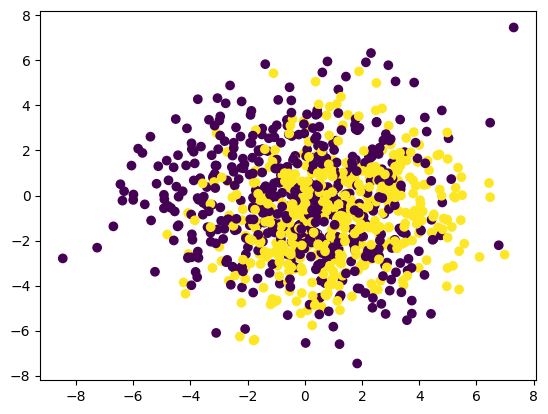

In [37]:
plt.scatter(X[:, 2], X[:, 3], c=y)

# Ансамбли: бустинги


Бустинг строится последовательно: каждое следующее дерево в нем обучается на основе результатов предыдущего, пытаясь уменьшить его ошибку. Как следствие, композиция будет иметь меньшее смещение, чем исходные базовые модели. Поэтому логично в качестве базовых моделей использовать те, которые изначально обладают небольшим разбросом и высоким смещением. Вопрос: какие это будут модели?
Еще одно соображение для выбора сильно смещенных моделей в том, что они банально быстрее учатся. Так как невозможно распараллелить обучение базовых моделей, то скорость их настройки становится серьезным вопросом. 

Что интересно, бустинги не очень хорошо работают с однородными данными - поэтому их нечасто применяют для текстов.

Расссмотрим квадратичную функцию потерь и композицию следующего вида: $ a = b_1 +  b_2 + ... + b_N $
Обучим только одно дерево $ a = b_1 $. Найдем примеры, для которых оно ошибается в  предсказании. Обучим для них еще одно дерево - $ b_2 $, которое будет предсказывать ошибку первого. Будем повторять это, пока не наберем K деревьев. Примерно так на верхнем уровне обучается бустинг. 


In [38]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

def eval_classifier(clf):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=43)
    n_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return np.mean(n_scores), np.std(n_scores)

In [39]:
results_accuracy = pd.DataFrame(0.0,
                                columns=["W/o ensembling", 'Bagging', "Bagging_with_mf", 'AdaBoost'],
                                index=['deep DTC', '1-level DTC', 'LR', 'SVC'])

In [7]:
acc_mean, acc_std = eval_classifier(DecisionTreeClassifier())

results_accuracy.loc['deep DTC', 'W/o ensembling'] = acc_mean
print(f"{acc_mean:.2f}, +- {acc_std:.2f}")

0.79, +- 0.05


In [8]:
acc_mean, acc_std = eval_classifier(DecisionTreeClassifier(max_depth=1))

results_accuracy.loc['1-level DTC', 'W/o ensembling'] = acc_mean
print(f"{acc_mean:.2f} +- {acc_std:.2f}")

0.68 +- 0.04


In [40]:
from sklearn.ensemble import BaggingClassifier

In [41]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, 
                      max_samples=1.0, max_features=1.0, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['deep DTC', 'Bagging'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.87, 0.04


In [11]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=10, 
                      max_samples=1.0, max_features=1.0, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['1-level DTC', 'Bagging'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.69, 0.04


In [12]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, 
                      max_samples=1.0, max_features=0.8, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['deep DTC', 'Bagging_with_mf'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.87, 0.03


In [13]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=10, 
                      max_samples=1.0, max_features=0.8, 
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['1-level DTC', 'Bagging_with_mf'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.69, 0.04


In [14]:
results_accuracy

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost
deep DTC,0.791333,0.869333,0.871333,0.0
1-level DTC,0.683333,0.687333,0.689667,0.0
LR,0.000000,0.000000,0.000000,0.0
SVC,0.000000,0.000000,0.000000,0.0


**Задание**: Дополните таблицу: обучите также логистическую регрессию с беггингом и без него.

In [42]:
acc_mean, acc_std = eval_classifier(LogisticRegression(max_iter=1000))

results_accuracy.loc['LR', 'W/o ensembling'] = acc_mean
print(f"LR W/o ensembling: {acc_mean:.2f}, +- {acc_std:.2f}")

LR W/o ensembling: 0.81, +- 0.03


In [16]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(LogisticRegression(max_iter=1000), n_estimators=10,
    max_samples=1.0, max_features=1.0,
    bootstrap=True, bootstrap_features=False))

results_accuracy.loc['LR', 'Bagging'] = acc_mean
print(f"LR with Bagging: {acc_mean:.2f}, +- {acc_std:.2f}")

LR with Bagging: 0.81, +- 0.03


In [17]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(LogisticRegression(max_iter=1000), n_estimators=10,
    max_samples=1.0, max_features=0.8,
    bootstrap=True, bootstrap_features=False))

results_accuracy.loc['LR', 'Bagging_with_mf'] = acc_mean
print(f"LR with Bagging_with_mf: {acc_mean:.2f}, +- {acc_std:.2f}")

LR with Bagging_with_mf: 0.81, +- 0.03


## AdaBoost

AdaBoost обучает каждый следующий классификатор на объектах, на которых ошибаются предыдущие (объекты с ошибками получают больший вес, без ошибок — меньший).

In [43]:
from sklearn.ensemble import AdaBoostClassifier

In [44]:
acc_mean, acc_std = eval_classifier(
    AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate=1.0))

results_accuracy.loc['deep DTC', 'AdaBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.79, 0.04


In [ ]:
acc_mean, acc_std = eval_classifier(
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50, learning_rate=1.0))

results_accuracy.loc['1-level DTC', 'AdaBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.81, 0.04


In [ ]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

results_to_show = results_accuracy.copy()

results_to_show.style.apply(highlight_max, props='font-weight: bold;', axis=1).format('{:.3f}')

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost
deep DTC,0.791,0.869,0.871,0.787
1-level DTC,0.683,0.687,0.690,0.813
LR,0.811,0.814,0.813,0.000
SVC,0.000,0.000,0.000,0.000


**Задание:** выясните, дадут ли улучшение бэггинг и бустинг над линейной регрессией. Объясните, почему так.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

def eval_regressor(model, X, y, cv=5, scoring='neg_mean_squared_error'):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return -scores.mean(), scores.std()

X_linear, y_linear = make_regression(n_samples=1000, n_features=2, noise=10, random_state=42)

np.random.seed(42)
X_nonlinear = np.random.rand(1000, 2) * 10
y_nonlinear = X_nonlinear[:, 0]**2 + X_nonlinear[:, 1] + np.random.normal(0, 1, 1000)

datasets = [
    ("Linear", X_linear, y_linear),
    ("Nonlinear", X_nonlinear, y_nonlinear)
]

regressors = {
    "Linear Regression": LinearRegression(),
    "Bagging + Linear Regression": BaggingRegressor(
        estimator=LinearRegression(), n_estimators=50, random_state=42
    ),
    "AdaBoost + Linear Regression": AdaBoostRegressor(
        estimator=LinearRegression(), n_estimators=50, learning_rate=1.0, random_state=42
    )
}

results_accuracy = pd.DataFrame(index=["Linear", "Nonlinear"], columns=regressors.keys())

for dataset_name, X, y in datasets:
    for model_name, model in regressors.items():
        mean_mse, std_mse = eval_regressor(model, X, y)
        results_accuracy.loc[dataset_name, model_name] = mean_mse
        print(f"{dataset_name} - {model_name}: MSE = {mean_mse:.2f}, Std = {std_mse:.2f}")

def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

results_to_show = results_accuracy.copy()
styled_results = results_to_show.style.apply(highlight_min, props='font-weight: bold;', axis=1).format('{:.3f}')
print("\nРезультаты (MSE, меньшее значение лучше):")
display(styled_results)

Linear - Linear Regression: MSE = 97.38, Std = 16.71
Linear - Bagging + Linear Regression: MSE = 97.35, Std = 16.70
Linear - AdaBoost + Linear Regression: MSE = 97.77, Std = 17.25
Nonlinear - Linear Regression: MSE = 58.49, Std = 2.32
Nonlinear - Bagging + Linear Regression: MSE = 58.42, Std = 2.31
Nonlinear - AdaBoost + Linear Regression: MSE = 58.56, Std = 2.14

Результаты (MSE, меньшее значение лучше):


,Linear Regression,Bagging + Linear Regression,AdaBoost + Linear Regression
Linear,97.376,97.353,97.772
Nonlinear,58.492,58.425,58.556


В коде для классификации использовались деревья решений, которые являются нелинейными и гибкими моделями. Ансамбли (например, AdaBoost) с деревьями дают значительное улучшение, так как деревья могут моделировать сложные зависимости.
Линейная регрессия, напротив, ограничена линейными гипотезами, поэтому ансамбли с ней менее эффективны на нелинейных данных.

Вопрос: Почему AdaBoost хуже работает на глубоких деревьях?

**Переобучение на шум:**
Глубокие деревья имеют высокую дисперсию и склонны подстраиваться под шум в данных. AdaBoost усиливает этот эффект, фокусируясь на шумовых примерах, что снижает обобщающую способность.
**Вычислительная сложность:**
Глубокие деревья требуют больше вычислительных ресурсов, а их комбинация в AdaBoost не оправдывает затрат, так как прирост точности минимален или отсутствует.
**Чувствительность к шуму:**
Наборы данных с шумом усиливают проблему переобучения глубоких деревьев, что делает AdaBoost менее стабильным.

# Градиентный бустинг

Рассмотрим композицию $a = \sum_{i} {\gamma_i b_i}$. Для начала выбирается какой-нибудь простой $\gamma_0, b_0$ (например, 0 и среднее). Формально каждая N-ая модель, начиная со второй, пытается приблизиить антиградиент функционала ошибки, взятый в точках ${z_i=a_{N-1}(x_i)}$:
$$s_i = -\dfrac{\partial L(y, z)}{\partial z}|_{z=a_{N-1}}$$
Подбор алгоритма при этом производится, приближая эту ошибку c точки зрения квадратичной функции потерь.
$$ b_i = arg \min_{b \in \mathcal{B}} {\sum (b_i(x) - s_i)^2} $$

Градиентный бустинг - довольно мощная метамодель, с огромным количеством параметров и хитростей. Мы сегодня остановимся только на основных. Для начала рассмотрим самый стандартный бустинг с использованием деревьев решений (CART). Параметры базовых моделей такие же, как и раньше, но настройка амого бустинга довольно сложна!

Важный вопрос при обучении модели - какую функцию ошибок выбрать? Какая задача возникает при обработке датасета с вином?

Для того, чтобы оценивать модель, полезны различные метрики - численные характеристики ее качества. При этом бустинги настолько галантны, что предоставляют нам возможность оценивать метрики прямо при обучении. Для этого необходимо задать тип метрики в конструкторе и eval_set при запуске fit().

На практике обычно используется один из трех вариантов бустинга - Xgboost, LightGBM или CatBoost.

### [XGBoost](https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf).
Плюсы:
- Позволяет легко паралелить вычисления (например на спарке)
- Легко использовать с sklearn и numpy (но с потерей производительности)
- Поддерживается обработка разреженных данных
- Предсортированные блоки, кэши, шардирование

Минусы:
- Нет поддержки GPU

[документация](https://xgboost.readthedocs.io/en/latest/)

  
### [LightGBM](https://papers.nips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
Плюсы:
- Поддержка GPU
- Метод Фишера для работы с категориальными признаками
- Уменьшение размера обучающей выборки (GOSS)
- Объединение разреженных признаков (EFB)

Минусы:
- Итерфейс не совместим с sklearn/numpy

[документация](https://lightgbm.readthedocs.io/en/latest/Python-API.html)

### [CatBoost](https://papers.nips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
Плюсы:
- Поддержка GPU
- Легко использовать с sklearn и numpy
- Более продвинутая работа с категориальными фичами
- Наши слоны
  
Минусы:
- Бывает работает хуже (возможно слабее эвристики), но с категориальными фичами — хорошо

[документация](https://catboost.ai/docs/concepts/python-quickstart.html)


In [47]:
from catboost import CatBoostClassifier # type: ignore

acc_mean, acc_std = eval_classifier(
    CatBoostClassifier(
        iterations=10,
        depth=1,
        learning_rate=1,
        loss_function='Logloss',
        verbose=True, 
        task_type='CPU'))

сat_boost = acc_mean

results_accuracy.loc['1-level DTC', 'CatBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.76, 0.04


In [48]:
from catboost import CatBoostClassifier

acc_mean, acc_std = eval_classifier(
    CatBoostClassifier(
        iterations=10,
        learning_rate=1,
        loss_function='Logloss',
        verbose=True, 
        task_type='CPU'))

сat_boost = acc_mean

results_accuracy.loc['deep DTC', 'CatBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.86, 0.03


In [49]:
from xgboost import XGBClassifier
acc_mean, acc_std = eval_classifier(XGBClassifier(objective='binary:logistic', random_state=42))

xg_boost = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

results_accuracy.loc['deep DTC', 'XGBoost'] = acc_mean

0.92, 0.03


In [50]:
acc_mean, acc_std = eval_classifier(XGBClassifier(objective='binary:logistic', max_depth=1, random_state=42))

xg_boost = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

results_accuracy.loc['1-level DTC', 'XGBoost'] = acc_mean

0.84, 0.03


In [51]:
results_to_show = results_accuracy.copy()
results_to_show.style.apply(highlight_max, props='font-weight: bold;', axis=1).format('{:.3f}')

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost,CatBoost,XGBoost
deep DTC,0.000,0.867,0.000,0.789,0.862,0.920
1-level DTC,0.000,0.000,0.000,0.000,0.759,0.841
LR,0.811,0.000,0.000,0.000,nan,nan
SVC,0.000,0.000,0.000,0.000,nan,nan


In [ ]:
import lightgbm as lgb

train_data = lgb.Dataset(X, label=y)

param = {'num_leaves': 31, 
         'objective': 'multiclass', 
         'num_class': 2, 
         'metric': ['multi_logloss']}

num_round = 10
boost = lgb.train(param, train_data, num_boost_round=10)

lg_boost = (boost.predict(X).argmax(axis=-1) == y).mean()

results_accuracy.loc['deep DTC', 'LightGBM'] = lg_boost
print(f"{lg_boost:.2f}")

In [53]:
results_to_show = results_accuracy.copy()

results_to_show.style.apply(highlight_max, props='font-weight: bold;', axis=1).format('{:.3f}')

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost,CatBoost,XGBoost
deep DTC,0.000,0.867,0.000,0.789,0.862,0.920
1-level DTC,0.000,0.000,0.000,0.000,0.759,0.841
LR,0.811,0.000,0.000,0.000,nan,nan
SVC,0.000,0.000,0.000,0.000,nan,nan


## Пример
Рассмотрим реальный датасет, и на его примере попробуем поработать с бустингом.

In [54]:
from sklearn import datasets
ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)


In [55]:
model = XGBRegressor(n_estimators=100, learning_rate=1, seed=SEED)
fit_params = {"eval_set":[(X_train, y_train),(X_test, y_test)], "verbose": False}
# Add verbose=False to avoid printing out updates with each cycle
model.fit(X_train, y_train,
            eval_set=[(X_train, y_train),(X_test, y_test)],
            verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [56]:
results = model.evals_result()

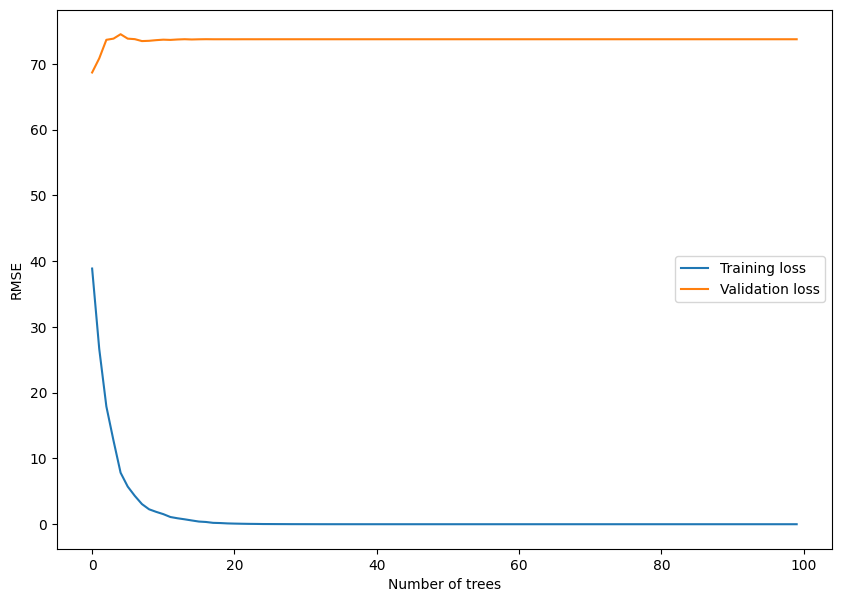

In [57]:
error_function = "rmse"
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"][error_function], label="Training loss")
plt.plot(results["validation_1"][error_function], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("RMSE")
plt.legend()

Как мы видим, хотя лосс при обучении падал и падал, на валидации метрики перестали улучшаться довольно рано. Это довольно плохой знак. Однако говорит ли это о катастрофической ситуации? Проверим переобучение с помощью кросс-валидации.

In [58]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X, Y, cv=10, scoring=["neg_root_mean_squared_error"],
                            return_train_score=True)
print("Train RMSE is", -cv_results['train_neg_root_mean_squared_error'].mean())
print("Test RMSE is", -cv_results['test_neg_root_mean_squared_error'].mean())


Train RMSE is 0.0006158542364544242
Test RMSE is 74.76829897433832


Кажется, у нас действительно серьезные проблемы. Попробуем уменьшить скорость обучения.


In [59]:
# train and eval model with smaller lr
model = XGBRegressor(n_estimators=100, learning_rate=0.01, seed=SEED)
fit_params = {"eval_set":[(X_train, y_train),(X_test, y_test)], "verbose": False}
# Add verbose=False to avoid printing out updates with each cycle
model.fit(X_train, y_train,
            eval_set=[(X_train, y_train),(X_test, y_test)],
            verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

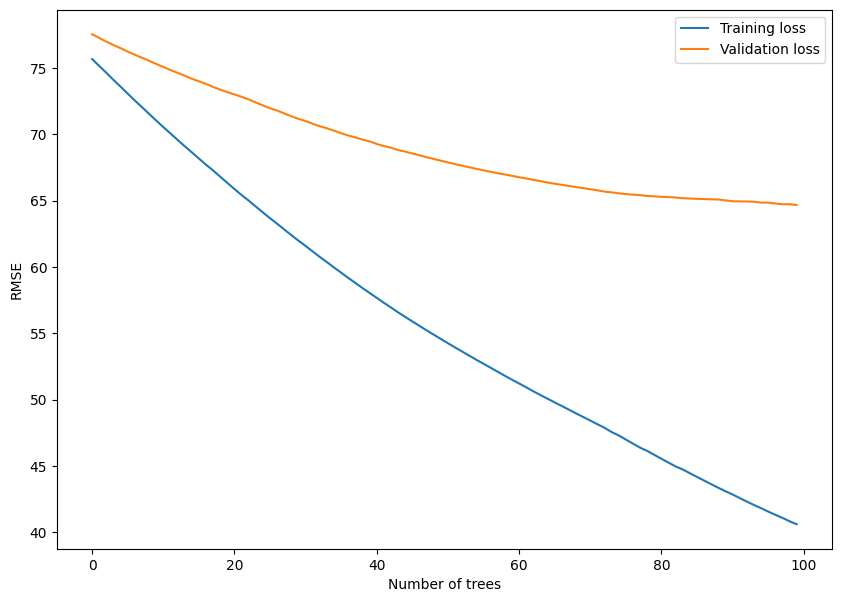

In [60]:
# plot results
results = model.evals_result()
error_function = "rmse"
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"][error_function], label="Training loss")
plt.plot(results["validation_1"][error_function], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("RMSE")
plt.legend()

Помогло ли это? Попробуем получить результаты лучше, поиграв с параметрами.

In [67]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X, Y, cv=10, scoring=["neg_root_mean_squared_error"],
                            return_train_score=True)
print("Train RMSE is", -cv_results['train_neg_root_mean_squared_error'].mean())
print("Test RMSE is", -cv_results['test_neg_root_mean_squared_error'].mean())


Train RMSE is 0.23005474051269678
Test RMSE is 64.66425443795261


In [ ]:
xgboost_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0]
}

model = XGBRegressor(seed=314159)
xgboost_best_grid = GridSearchCV(model, xgboost_params, cv=7, n_jobs=-1, return_train_score=True)
xgboost_best_grid.fit(X_reg_train, y_reg_train, eval_set=[(X_reg_test, y_reg_test)], verbose=False)
print("Лучшие параметры XGBoost:", xgboost_best_grid.best_params_)
print("Test RMSE:", np.sqrt(mean_squared_error(y_reg_test, xgboost_best_grid.predict(X_reg_test))))

Так как параметров довольно много, может быть разумно автоматизировать их поиск. Для этого воспользуемся поиском по решетке.

In [69]:
from sklearn.model_selection import GridSearchCV

model = XGBRegressor(
    objective="reg:squarederror",
    seed=SEED,
    verbosity=0
)
xgboost_params = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 1.0],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 2],
    "n_estimators": [300, 500]
}
fit_params = {
    "eval_set": [(X_train, y_train), (X_test, y_test)],
    "verbose": False
}

xgboost_best_grid = GridSearchCV(
    model,
    xgboost_params,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    return_train_score=True
)

xgboost_best_grid.fit(X_train, y_train, **fit_params)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [300, 500],
                         'reg_alpha': [0, 0.1], 'reg_lambda': [1, 2],
                         'subsample': [0.7, 0.9]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [70]:
print(xgboost_best_grid.best_params_)

{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.7}


Давайте проверим, какую точность мы получим с лучшими параметрами.

In [71]:
print("Best RMSE:", -xgboost_best_grid.best_score_)
print("Best parameters:")
for k, v in xgboost_best_grid.best_params_.items():
    print(f"  {k}: {v}")

Best RMSE: 55.95517068533437
Best parameters:
  colsample_bytree: 0.7
  learning_rate: 0.01
  max_depth: 3
  n_estimators: 300
  reg_alpha: 0.1
  reg_lambda: 2
  subsample: 0.7


**Задание:** Проведите обучение и с LightGBM/CatBoost. Какие лучшие точности у вас получилось получить?

In [72]:
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

SEED = 42

np.random.seed(SEED)
X = np.random.rand(1000, 5) * 10
y = X[:, 0] * 2 + X[:, 1] + np.random.normal(0, 1, 1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

model_xgb = XGBRegressor(objective="reg:squarederror", seed=SEED, verbosity=0)
xgboost_params = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 1.0],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 2],
    "n_estimators": [300, 500]
}
fit_params = {
    "eval_set": [(X_train, y_train), (X_test, y_test)],
    "verbose": False
}

xgboost_best_grid = GridSearchCV(
    model_xgb,
    xgboost_params,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    return_train_score=True
)
xgboost_best_grid.fit(X_train, y_train, **fit_params)

print("XGBoost Results:")
print(xgboost_best_grid.best_params_)
print("Best RMSE:", -xgboost_best_grid.best_score_)
print("Best parameters:")
for k, v in xgboost_best_grid.best_params_.items():
    print(f"  {k}: {v}")

model_lgb = LGBMRegressor(random_state=SEED, verbose=-1)
lightgbm_params = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 1.0],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 2],
    "n_estimators": [300, 500]
}

lightgbm_best_grid = GridSearchCV(
    model_lgb,
    lightgbm_params,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    return_train_score=True
)
lightgbm_best_grid.fit(X_train, y_train)

print("\nLightGBM Results:")
print(lightgbm_best_grid.best_params_)
print("Best RMSE:", -lightgbm_best_grid.best_score_)
print("Best parameters:")
for k, v in lightgbm_best_grid.best_params_.items():
    print(f"  {k}: {v}")

model_cat = CatBoostRegressor(random_seed=SEED, verbose=0)
catboost_params = {
    "depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9],
    "colsample_bylevel": [0.7, 1.0],
    "l2_leaf_reg": [1, 2],
    "iterations": [300, 500]
}

catboost_best_grid = GridSearchCV(
    model_cat,
    catboost_params,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    return_train_score=True
)
catboost_best_grid.fit(X_train, y_train)

print("\nCatBoost Results:")
print(catboost_best_grid.best_params_)
print("Best RMSE:", -catboost_best_grid.best_score_)
print("Best parameters:")
for k, v in catboost_best_grid.best_params_.items():
    print(f"  {k}: {v}")

print("\nComparison of Best RMSE:")
print(f"XGBoost: {-xgboost_best_grid.best_score_:.4f}")
print(f"LightGBM: {-lightgbm_best_grid.best_score_:.4f}")
print(f"CatBoost: {-catboost_best_grid.best_score_:.4f}")

XGBoost Results:
{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.7}
Best RMSE: 1.07591919900589
Best parameters:
  colsample_bytree: 1.0
  learning_rate: 0.01
  max_depth: 3
  n_estimators: 500
  reg_alpha: 0
  reg_lambda: 1
  subsample: 0.7

LightGBM Results:
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.7}
Best RMSE: 1.0766292259011807
Best parameters:
  colsample_bytree: 0.7
  learning_rate: 0.05
  max_depth: 3
  n_estimators: 300
  reg_alpha: 0.1
  reg_lambda: 2
  subsample: 0.7

CatBoost Results:
{'colsample_bylevel': 1.0, 'depth': 3, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.05, 'subsample': 0.7}
Best RMSE: 1.036005609720561
Best parameters:
  colsample_bylevel: 1.0
  depth: 3
  iterations: 300
  l2_leaf_reg: 1
  learning_rate: 0.05
  subsample: 0.7

Comparison of Best RMSE:
XGBoost: 1.0759
Li

**Задание:** Постройте графики предсказаний для первых двух PCA фичей для бустингов разной глубины/разного числа деревьев.

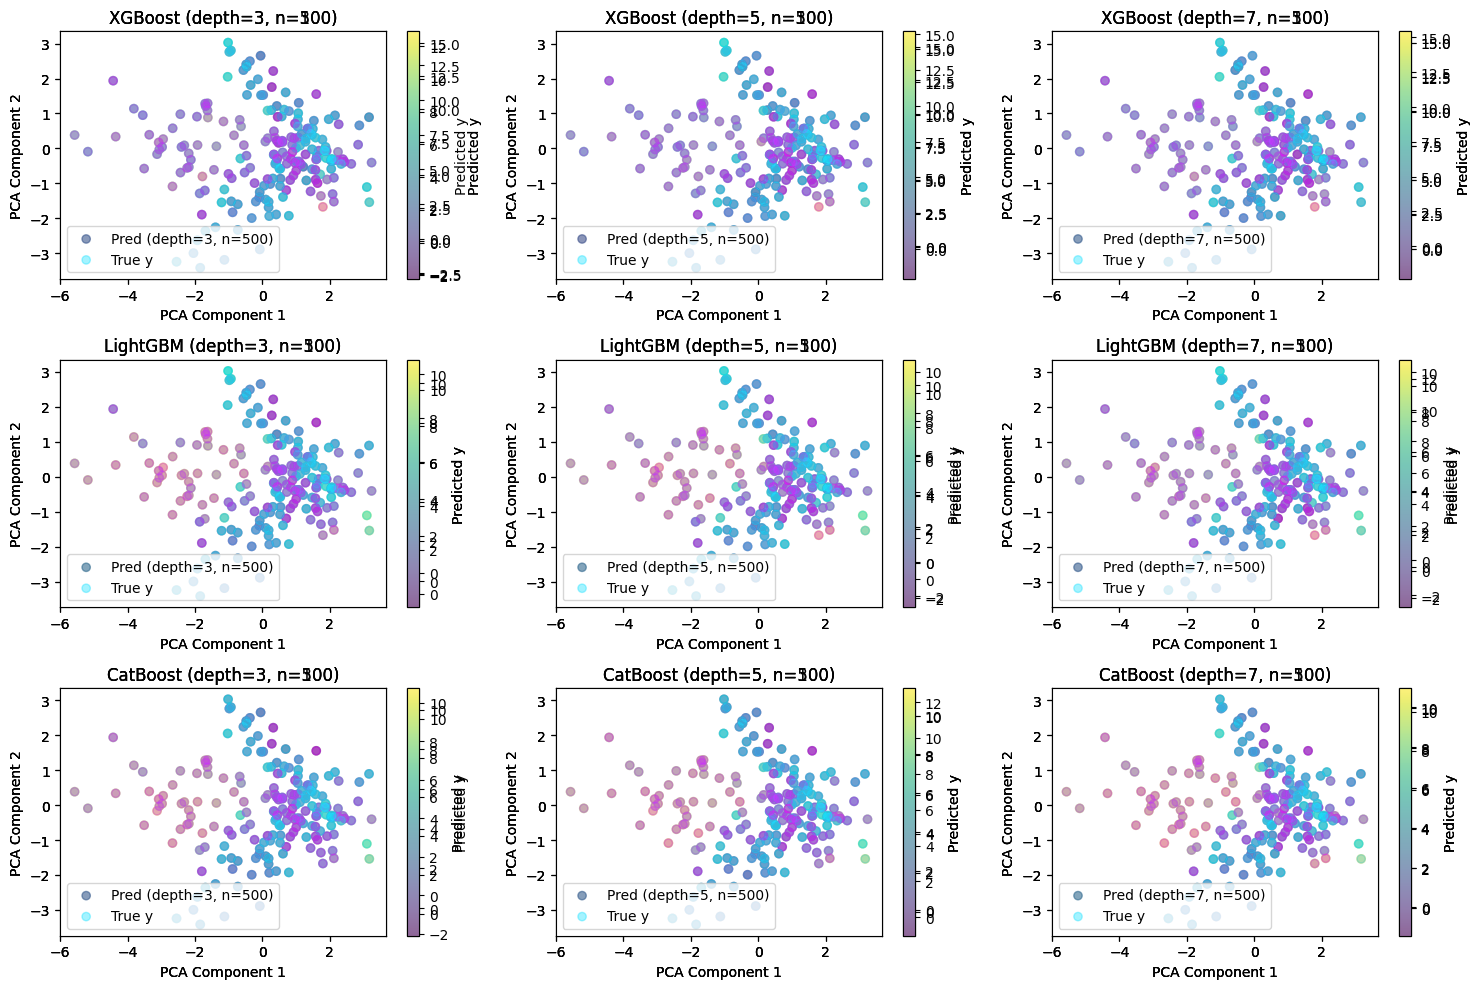

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler

SEED = 42

X, y = make_classification(n_samples=1000, n_features=5, n_informative=4, n_redundant=1, random_state=SEED)
y = y * 10 + np.random.normal(0, 1, 1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

def train_and_predict(model_class, max_depth, n_estimators, X_train, y_train, X_test):
    if model_class == XGBRegressor:
        model = model_class(max_depth=max_depth, n_estimators=n_estimators, random_state=SEED, verbosity=0)
    elif model_class == LGBMRegressor:
        model = model_class(max_depth=max_depth, n_estimators=n_estimators, random_state=SEED, verbose=-1)
    elif model_class == CatBoostRegressor:
        model = model_class(depth=max_depth, iterations=n_estimators, random_seed=SEED, verbose=0)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

models = {
    "XGBoost": XGBRegressor,
    "LightGBM": LGBMRegressor,
    "CatBoost": CatBoostRegressor
}
depths = [3, 5, 7]
n_estimators_list = [100, 300, 500]

plt.figure(figsize=(15, 10))
for idx, (model_name, model_class) in enumerate(models.items(), 1):
    for depth in depths:
        for n_estimators in n_estimators_list:
            y_pred = train_and_predict(model_class, depth, n_estimators, X_train_pca, y_train, X_test_pca)
            
            plt.subplot(3, 3, (idx-1)*3 + depths.index(depth) + 1)
            scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='viridis', alpha=0.6, label=f'Pred (depth={depth}, n={n_estimators})')
            plt.colorbar(scatter, label='Predicted y')
            plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='cool', alpha=0.4, label='True y')
            plt.title(f'{model_name} (depth={depth}, n={n_estimators})')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.legend()

plt.tight_layout()
plt.show()

**Задание**: Постройте график зависимости точности от глубины

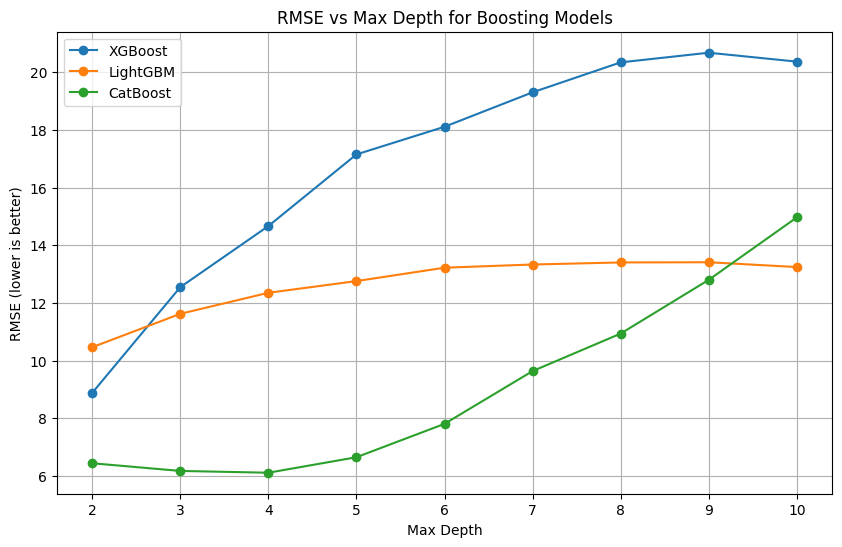

XGBoost: Best RMSE = 8.8842 at depth = 2
LightGBM: Best RMSE = 10.4662 at depth = 2
CatBoost: Best RMSE = 6.1133 at depth = 4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.datasets import make_regression

SEED = 42

X, y = make_regression(n_samples=1000, n_features=5, noise=0.1, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

max_depths = range(2, 11)
n_estimators = 300

results = {
    "XGBoost": [],
    "LightGBM": [],
    "CatBoost": []
}

for depth in max_depths:
    model_xgb = XGBRegressor(max_depth=depth, n_estimators=n_estimators, random_state=SEED, verbosity=0)
    scores_xgb = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    results["XGBoost"].append(-scores_xgb.mean())

    model_lgb = LGBMRegressor(max_depth=depth, n_estimators=n_estimators, random_state=SEED, verbose=-1)
    scores_lgb = cross_val_score(model_lgb, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    results["LightGBM"].append(-scores_lgb.mean())

    model_cat = CatBoostRegressor(depth=depth, iterations=n_estimators, random_seed=SEED, verbose=0)
    scores_cat = cross_val_score(model_cat, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    results["CatBoost"].append(-scores_cat.mean())

plt.figure(figsize=(10, 6))
for model_name, rmse_values in results.items():
    plt.plot(max_depths, rmse_values, marker='o', label=model_name)

plt.xlabel('Max Depth')
plt.ylabel('RMSE (lower is better)')
plt.title('RMSE vs Max Depth for Boosting Models')
plt.legend()
plt.grid(True)
plt.show()

for model_name, rmse_values in results.items():
    best_rmse = min(rmse_values)
    best_depth = max_depths[rmse_values.index(best_rmse)]
    print(f"{model_name}: Best RMSE = {best_rmse:.4f} at depth = {best_depth}")